# 1 导包和数据读取

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
#from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

In [2]:
#load_dataset
lanes_df = pd.read_csv('/kaggle/input/itsystem-data/Lane.csv')  
light_df = pd.read_csv('/kaggle/input/itsystem-data/Light_status.csv')
roads_df = pd.read_csv('/kaggle/input/itsystem-data/Entrance_road.csv') 
flow_df = pd.read_csv('/kaggle/input/itsystem-data/Flow.csv')

# 2 处理数据

## Lane.csv

In [3]:
lanes_df.head()

,LANE_ID,ARM_ID,LANE_NAME,DIR
0,1,E,左,L
1,1,N,左,L
2,1,S,左,L
3,1,W,左,L
4,2,E,直,S


In [4]:
lanes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LANE_ID    16 non-null     int64 
 1   ARM_ID     16 non-null     object
 2   LANE_NAME  16 non-null     object
 3   DIR        16 non-null     object
dtypes: int64(1), object(3)
memory usage: 640.0+ bytes


## Light_status.csv

In [5]:
light_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105844 entries, 0 to 105843
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   CYCLE_START_TIME  105844 non-null  object
 1   STAGE_START_TIME  105844 non-null  object
 2   STAGE_END_TIME    105844 non-null  object
 3   STAGE_LENGTH      105844 non-null  int64 
 4   GREEN_TIME        105844 non-null  int64 
 5   GREEN_FLASH_TIME  105844 non-null  int64 
 6   YELLOW_TIME       105844 non-null  int64 
 7   ALL_RED_TIME      105844 non-null  int64 
 8   CHANNELS          105844 non-null  object
 9   LANES             105844 non-null  object
 10  PHASES            105844 non-null  object
 11  LANE_FUNCS        105844 non-null  object
dtypes: int64(5), object(7)
memory usage: 9.7+ MB


In [6]:
# 转换成日期属性
light_df['CYCLE_START_TIME'] = pd.to_datetime(light_df['CYCLE_START_TIME'])
light_df['STAGE_START_TIME'] = pd.to_datetime(light_df['STAGE_START_TIME'])
light_df['STAGE_END_TIME'] = pd.to_datetime(light_df['STAGE_END_TIME'])

In [7]:
# 删除GREEN_FLASH_TIME YELLOW_TIME列
light_df.drop('GREEN_FLASH_TIME',axis=1,inplace=True)
light_df.drop('YELLOW_TIME',axis=1,inplace=True)

In [8]:
# 查找STAGE_LENGTH或GREEN_TIME小于0的行，并删除
neg_stage_length =light_df[(light_df['STAGE_LENGTH']<0)|(light_df['GREEN_TIME']<0)]
light_df = light_df.drop(neg_stage_length.index,axis=0)
light_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105759 entries, 0 to 105843
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   CYCLE_START_TIME  105759 non-null  datetime64[ns]
 1   STAGE_START_TIME  105759 non-null  datetime64[ns]
 2   STAGE_END_TIME    105759 non-null  datetime64[ns]
 3   STAGE_LENGTH      105759 non-null  int64         
 4   GREEN_TIME        105759 non-null  int64         
 5   ALL_RED_TIME      105759 non-null  int64         
 6   CHANNELS          105759 non-null  object        
 7   LANES             105759 non-null  object        
 8   PHASES            105759 non-null  object        
 9   LANE_FUNCS        105759 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(4)
memory usage: 8.9+ MB


In [9]:
# 处理LANES列
light_df['released_lanes'] = light_df['LANES'].str.split(',') # 用，分割

In [10]:
# 将放行车道号“_”前代表的进口道，1，2，3，4替换为为W，N，E，S。

# 定义一个替换函数 replace_dir
def replace_lanes(lanes):
    replaced = []
    for i in lanes:
        i = i.replace('1_', 'W_')
        i = i.replace('2_', 'N_')
        i = i.replace('3_', 'E_')
        i = i.replace('4_', 'S_')
        
        replaced.append(i)
    
    return replaced

# apply替换
light_df['released_lanes'] = light_df['released_lanes'].apply(replace_lanes)

In [11]:
light_df['released_lanes']

0         [W_2, W_3, E_2, W_4, E_3, E_4]
1         [W_2, W_3, E_2, W_4, E_3, E_4]
2         [W_2, W_3, E_2, W_4, E_3, E_4]
3         [W_2, W_3, E_2, W_4, E_3, E_4]
4         [W_2, W_3, E_2, W_4, E_3, E_4]
                       ...              
105839                        [N_1, S_1]
105840                        [N_1, S_1]
105841                        [N_1, S_1]
105842                        [N_1, S_1]
105843                        [N_1, S_1]
Name: released_lanes, Length: 105759, dtype: object

In [12]:
# 调换顺序，改为前面为车道号，后面为进口道，并去掉下划线
light_df['released_lanes'] = light_df['released_lanes'].apply(lambda lanes: [lane.replace('_', '')[-1] + lane.replace('_', '')[:-1] for lane in lanes])

In [13]:
light_df.head(40000)

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
0,2023-08-01 00:01:08,2023-08-01 00:01:08,2023-08-01 00:01:30,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
1,2023-08-01 00:02:18,2023-08-01 00:02:18,2023-08-01 00:02:40,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2,2023-08-01 00:04:38,2023-08-01 00:04:38,2023-08-01 00:05:00,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
3,2023-08-01 00:05:48,2023-08-01 00:05:48,2023-08-01 00:06:10,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
4,2023-08-01 00:06:58,2023-08-01 00:06:58,2023-08-01 00:07:20,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...,...,...,...,...
40030,2023-08-11 07:07:18,2023-08-11 07:08:02,2023-08-11 07:08:26,24,21,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
40031,2023-08-11 07:08:43,2023-08-11 07:09:27,2023-08-11 07:09:51,24,21,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
40032,2023-08-11 07:10:08,2023-08-11 07:10:52,2023-08-11 07:11:16,24,21,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
40033,2023-08-11 07:11:33,2023-08-11 07:12:17,2023-08-11 07:12:58,41,38,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"


In [14]:
# 按LANES分组
lanes_unique = light_df['LANES'].unique()
lanes_unique

array(['1_2,1_3,3_2,1_4,3_3,3_4', '1_1,3_1', '2_2,2_3,2_4,4_2,4_3,4_4',
       '2_1,4_1'], dtype=object)

In [15]:
# 按LANES分组
df_ligth_2W3W2E4W3E4E=light_df[light_df['LANES']=='1_2,1_3,3_2,1_4,3_3,3_4']
df_ligth_1W1E=light_df[light_df['LANES']=='1_1,3_1']
df_ligth_2N3N4N2S3S4S=light_df[light_df['LANES']=='2_2,2_3,2_4,4_2,4_3,4_4']
df_ligth_1N1S=light_df[light_df['LANES']=='2_1,4_1']

In [16]:
df_ligth_2W3W2E4W3E4E

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
0,2023-08-01 00:01:08,2023-08-01 00:01:08,2023-08-01 00:01:30,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
1,2023-08-01 00:02:18,2023-08-01 00:02:18,2023-08-01 00:02:40,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2,2023-08-01 00:04:38,2023-08-01 00:04:38,2023-08-01 00:05:00,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
3,2023-08-01 00:05:48,2023-08-01 00:05:48,2023-08-01 00:06:10,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
4,2023-08-01 00:06:58,2023-08-01 00:06:58,2023-08-01 00:07:20,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...,...,...,...,...
71245,2023-08-27 23:55:01,2023-08-27 23:55:01,2023-08-27 23:55:23,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
71246,2023-08-27 23:56:11,2023-08-27 23:56:11,2023-08-27 23:56:33,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
71247,2023-08-27 23:57:21,2023-08-27 23:57:21,2023-08-27 23:57:43,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
71248,2023-08-27 23:58:31,2023-08-27 23:58:31,2023-08-27 23:58:53,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"


In [17]:
# 删除STAGE_START_TIME，STAGE_END_TIME，LANES
df_ligth_2W3W2E4W3E4E.drop(['STAGE_START_TIME','STAGE_END_TIME','LANES'],axis=1,inplace=True)

In [18]:
#处理时间索引，按CYCLE_START_TIME为时间索引，从00:05:00开始，每五分钟为一个时间段

In [19]:
# 删除2023-08-01 00:05:00前的数据
df_ligth_2W3W2E4W3E4E=df_ligth_2W3W2E4W3E4E.drop(index=df_ligth_2W3W2E4W3E4E.index[:3])
df_ligth_2W3W2E4W3E4E=df_ligth_2W3W2E4W3E4E.reset_index(drop=True)
df_ligth_2W3W2E4W3E4E

,CYCLE_START_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
0,2023-08-01 00:05:48,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
1,2023-08-01 00:06:58,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2,2023-08-01 00:08:08,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
3,2023-08-01 00:09:18,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
4,2023-08-01 00:10:28,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...,...
26447,2023-08-27 23:55:01,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
26448,2023-08-27 23:56:11,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
26449,2023-08-27 23:57:21,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
26450,2023-08-27 23:58:31,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"


In [20]:
# 将第一个数据改成2023-08-01 00:05:00
#df_ligth_2W3W2E4W3E4E['CYCLE_START_TIME'][0]=pd.to_datetime("2023-08-01 00:05:00")
#df_ligth_2W3W2E4W3E4E.head()

In [21]:
# 将CYCLE_START_TIME设置为时间索引
df_ligth_2W3W2E4W3E4E=df_ligth_2W3W2E4W3E4E.set_index('CYCLE_START_TIME')
#df_ligth_2W3W2E4W3E4E.head(20)

In [22]:
# 对数据进行重新采样，以五分钟为一个时间段，并选择从00:05:00开始的数据：
start_time = pd.to_datetime("2023-08-01 00:05:00")
df_ligth_2W3W2E4W3E4E = df_ligth_2W3W2E4W3E4E.resample('5Min',label='left', closed='right').first().loc[start_time:] 

In [23]:
df_ligth_2W3W2E4W3E4E

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:10:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:15:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:20:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:25:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...
2023-08-27 23:35:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-27 23:40:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-27 23:45:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"


In [24]:
df_ligth_1W1E.head(10)

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
14944,2023-07-31 23:59:58,2023-08-01 00:00:20,2023-08-01 00:00:33,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14945,2023-08-01 00:01:08,2023-08-01 00:01:30,2023-08-01 00:01:43,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14946,2023-08-01 00:02:18,2023-08-01 00:02:40,2023-08-01 00:02:53,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14947,2023-08-01 00:02:18,2023-08-01 00:03:50,2023-08-01 00:04:03,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14948,2023-08-01 00:04:38,2023-08-01 00:05:00,2023-08-01 00:05:13,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14949,2023-08-01 00:05:48,2023-08-01 00:06:10,2023-08-01 00:06:23,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14950,2023-08-01 00:06:58,2023-08-01 00:07:20,2023-08-01 00:07:33,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14951,2023-08-01 00:08:08,2023-08-01 00:08:30,2023-08-01 00:08:43,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14952,2023-08-01 00:09:18,2023-08-01 00:09:40,2023-08-01 00:09:53,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14953,2023-08-01 00:10:28,2023-08-01 00:10:50,2023-08-01 00:11:03,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"


In [25]:
# 删除STAGE_START_TIME，STAGE_END_TIME，LANES
df_ligth_1W1E.drop(['STAGE_START_TIME','STAGE_END_TIME','LANES'],axis=1,inplace=True)

In [26]:
# 删除2023-08-01 00:05:00前的数据
df_ligth_1W1E = df_ligth_1W1E.drop(index=df_ligth_1W1E.index[:5])
df_ligth_1W1E=df_ligth_1W1E.reset_index(drop=True)
df_ligth_1W1E.head()

,CYCLE_START_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
0,2023-08-01 00:05:48,13,9,1,"1,9","4,9",12,"[1W, 1E]"
1,2023-08-01 00:06:58,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2,2023-08-01 00:08:08,13,9,1,"1,9","4,9",12,"[1W, 1E]"
3,2023-08-01 00:09:18,13,9,1,"1,9","4,9",12,"[1W, 1E]"
4,2023-08-01 00:10:28,13,9,1,"1,9","4,9",12,"[1W, 1E]"


In [27]:
# 将第一条数据改成2023-08-01 00:05:00
#df_ligth_1W1E['CYCLE_START_TIME'][0]=pd.to_datetime('2023-08-01 00:05:00')

In [28]:
# 设置时间索引
df_ligth_1W1E=df_ligth_1W1E.set_index("CYCLE_START_TIME")
df_ligth_1W1E.head()

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:48,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:06:58,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:08:08,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:09:18,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:10:28,13,9,1,"1,9","4,9",12,"[1W, 1E]"


In [29]:
# 对数据进行重新采样，以五分钟为一个时间段，并选择从00:05:00开始的数据：
df_ligth_1W1E = df_ligth_1W1E.resample('5Min',label='left',closed = 'right').first().loc[start_time:]

In [30]:
df_ligth_1W1E

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:10:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:15:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:20:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:25:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
...,...,...,...,...,...,...,...
2023-08-27 23:35:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-27 23:40:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-27 23:45:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"


In [31]:
df_ligth_2N3N4N2S3S4S.head(10)

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
29861,2023-07-31 23:59:58,2023-08-01 00:00:33,2023-08-01 00:00:55,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29862,2023-08-01 00:01:08,2023-08-01 00:01:43,2023-08-01 00:02:05,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29863,2023-08-01 00:02:18,2023-08-01 00:02:53,2023-08-01 00:03:15,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29864,2023-08-01 00:02:18,2023-08-01 00:04:03,2023-08-01 00:04:25,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29865,2023-08-01 00:04:38,2023-08-01 00:05:13,2023-08-01 00:05:35,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29866,2023-08-01 00:05:48,2023-08-01 00:06:23,2023-08-01 00:06:58,35,32,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29867,2023-08-01 00:06:58,2023-08-01 00:07:33,2023-08-01 00:07:55,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29868,2023-08-01 00:08:08,2023-08-01 00:08:43,2023-08-01 00:09:05,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29869,2023-08-01 00:09:18,2023-08-01 00:09:53,2023-08-01 00:10:15,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29870,2023-08-01 00:10:28,2023-08-01 00:11:03,2023-08-01 00:11:25,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"


In [32]:
# 删除STAGE_START_TIME，STAGE_END_TIME，LANES
df_ligth_2N3N4N2S3S4S.drop(['STAGE_START_TIME','STAGE_END_TIME','LANES'],axis=1,inplace=True)

In [33]:
# 删除数据 处理索引
df_ligth_2N3N4N2S3S4S = df_ligth_2N3N4N2S3S4S.drop(index=df_ligth_2N3N4N2S3S4S.index[:5])
df_ligth_2N3N4N2S3S4S = df_ligth_2N3N4N2S3S4S.reset_index(drop=True)

In [34]:
# 修改数据
#df_ligth_2N3N4N2S3S4S['CYCLE_START_TIME'][0]=pd.to_datetime('2023-08-01 00:05:00')

In [35]:
# 设置时间索引
df_ligth_2N3N4N2S3S4S=df_ligth_2N3N4N2S3S4S.set_index("CYCLE_START_TIME")

In [36]:
# 重新采样
df_ligth_2N3N4N2S3S4S=df_ligth_2N3N4N2S3S4S.resample('5Min',label='left',closed='right').first().loc[start_time:]

In [37]:
df_ligth_2N3N4N2S3S4S

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:00,35.0,32.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-01 00:10:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-01 00:15:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-01 00:20:00,23.0,20.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-01 00:25:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
...,...,...,...,...,...,...,...
2023-08-27 23:35:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-27 23:40:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-27 23:45:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"


In [38]:
df_ligth_1N1S.head(10)

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
44812,2023-07-31 23:59:58,2023-08-01 00:00:55,2023-08-01 00:01:08,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44813,2023-08-01 00:01:08,2023-08-01 00:02:05,2023-08-01 00:02:18,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44814,2023-08-01 00:02:18,2023-08-01 00:03:15,2023-08-01 00:03:50,35,31,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44815,2023-08-01 00:02:18,2023-08-01 00:04:25,2023-08-01 00:04:38,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44816,2023-08-01 00:04:38,2023-08-01 00:05:35,2023-08-01 00:05:48,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44817,2023-08-01 00:06:58,2023-08-01 00:07:55,2023-08-01 00:08:08,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44818,2023-08-01 00:08:08,2023-08-01 00:09:05,2023-08-01 00:09:18,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44819,2023-08-01 00:09:18,2023-08-01 00:10:15,2023-08-01 00:10:28,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44820,2023-08-01 00:10:28,2023-08-01 00:11:25,2023-08-01 00:11:38,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44821,2023-08-01 00:11:38,2023-08-01 00:12:35,2023-08-01 00:12:48,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"


In [39]:
# 删除STAGE_START_TIME，STAGE_END_TIME，LANES
df_ligth_1N1S.drop(['STAGE_START_TIME','STAGE_END_TIME','LANES'],axis=1,inplace=True)

In [40]:
# 删除数据 整理索引
df_ligth_1N1S = df_ligth_1N1S.drop(index=df_ligth_1N1S.index[:4])
df_ligth_1N1S=df_ligth_1N1S.reset_index(drop=True)

In [41]:
# 修改数据
#df_ligth_1N1S['CYCLE_START_TIME'][0]=pd.to_datetime("2023-08-01 00:05:00")

In [42]:
# 设置时间索引
df_ligth_1N1S = df_ligth_1N1S.set_index("CYCLE_START_TIME")

In [43]:
# 重新采样
df_ligth_1N1S = df_ligth_1N1S.resample("5Min",label="left",closed="right").first().loc[start_time:]

In [44]:
df_ligth_1N1S

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-01 00:10:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-01 00:15:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-01 00:20:00,12.0,8.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-01 00:25:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
...,...,...,...,...,...,...,...
2023-08-27 23:35:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-27 23:40:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-27 23:45:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"


## Entrance_road.csv

In [45]:
roads_df.head()

,ARM_ID,ARM_NAME,DIR
0,E,东进口道,E
1,N,北进口道,N
2,S,南进口道,S
3,W,西进口道,W


## Flow.csv

In [46]:
flow_df

,LANE_ID,ARM_ID,START_TIME,END_TIME,VOLUMN_5MIN
0,1,E,2023-08-01 00:05:00,2023-08-01 00:10:00,2
1,1,E,2023-08-01 00:10:00,2023-08-01 00:15:00,1
2,1,E,2023-08-01 00:15:00,2023-08-01 00:20:00,0
3,1,E,2023-08-01 00:20:00,2023-08-01 00:25:00,1
4,1,E,2023-08-01 00:25:00,2023-08-01 00:30:00,0
...,...,...,...,...,...
120775,4,W,2023-08-27 23:35:00,2023-08-27 23:40:00,0
120776,4,W,2023-08-27 23:40:00,2023-08-27 23:45:00,0
120777,4,W,2023-08-27 23:45:00,2023-08-27 23:50:00,0
120778,4,W,2023-08-27 23:50:00,2023-08-27 23:55:00,0


In [47]:
flow_df['START_TIME'] = pd.to_datetime(flow_df['START_TIME'])
flow_df['END_TIME'] = pd.to_datetime(flow_df['END_TIME'])

In [48]:
flow_df['LANE_ARM']=flow_df['LANE_ID'].astype(str)+flow_df['ARM_ID']

In [49]:
lane_arm = flow_df.pop("LANE_ARM")
flow_df.insert(2,'LANE_ARM',lane_arm)

In [50]:
flow_df.drop(['LANE_ID','ARM_ID'],axis = 1,inplace = True)

In [51]:
flow_df

,LANE_ARM,START_TIME,END_TIME,VOLUMN_5MIN
0,1E,2023-08-01 00:05:00,2023-08-01 00:10:00,2
1,1E,2023-08-01 00:10:00,2023-08-01 00:15:00,1
2,1E,2023-08-01 00:15:00,2023-08-01 00:20:00,0
3,1E,2023-08-01 00:20:00,2023-08-01 00:25:00,1
4,1E,2023-08-01 00:25:00,2023-08-01 00:30:00,0
...,...,...,...,...
120775,4W,2023-08-27 23:35:00,2023-08-27 23:40:00,0
120776,4W,2023-08-27 23:40:00,2023-08-27 23:45:00,0
120777,4W,2023-08-27 23:45:00,2023-08-27 23:50:00,0
120778,4W,2023-08-27 23:50:00,2023-08-27 23:55:00,0


In [52]:
LANE_ARM_uniqe =flow_df['LANE_ARM'].unique()
LANE_ARM_uniqe

array(['1E', '1N', '1S', '1W', '2E', '2N', '2S', '2W', '3E', '3N', '3S',
       '3W', '4E', '4N', '4S', '4W'], dtype=object)

In [53]:
# 按LANE_ARM分组
df_flow_1E = flow_df[flow_df['LANE_ARM']=='1E']
df_flow_1N = flow_df[flow_df['LANE_ARM']=='1N']
df_flow_1S = flow_df[flow_df['LANE_ARM']=='1S']
df_flow_1W = flow_df[flow_df['LANE_ARM']=='1W']
df_flow_2E = flow_df[flow_df['LANE_ARM']=='2E']
df_flow_2N = flow_df[flow_df['LANE_ARM']=='2N']
df_flow_2S = flow_df[flow_df['LANE_ARM']=='2S']
df_flow_2W = flow_df[flow_df['LANE_ARM']=='2W']
df_flow_3E = flow_df[flow_df['LANE_ARM']=='3E']
df_flow_3N = flow_df[flow_df['LANE_ARM']=='3N']
df_flow_3S = flow_df[flow_df['LANE_ARM']=='3S']
df_flow_3W = flow_df[flow_df['LANE_ARM']=='3W']
df_flow_4E = flow_df[flow_df['LANE_ARM']=='4E']
df_flow_4N = flow_df[flow_df['LANE_ARM']=='4N']
df_flow_4S = flow_df[flow_df['LANE_ARM']=='4S']
df_flow_4W = flow_df[flow_df['LANE_ARM']=='4W']

In [54]:
flow_LANE_ARM = [df_flow_1E
,df_flow_1N
,df_flow_1S
,df_flow_1W
,df_flow_2E
,df_flow_2N
,df_flow_2S
,df_flow_2W
,df_flow_3E
,df_flow_3N
,df_flow_3S
,df_flow_3W
,df_flow_4E
,df_flow_4N
,df_flow_4S
,df_flow_4W]

In [55]:
for i in flow_LANE_ARM:
    print(i.shape)
    #i = i.reset_index(drop=True)


(7549, 4)
(7549, 4)
(7549, 4)
(7548, 4)
(7549, 4)
(7549, 4)
(7549, 4)
(7548, 4)
(7549, 4)
(7549, 4)
(7549, 4)
(7548, 4)
(7549, 4)
(7549, 4)
(7549, 4)
(7548, 4)


In [56]:
df_flow_1E = df_flow_1E.set_index('START_TIME')
df_flow_1N = df_flow_1N.set_index('START_TIME')
df_flow_1S = df_flow_1S.set_index('START_TIME')
df_flow_1W = df_flow_1W.set_index('START_TIME')
df_flow_2E = df_flow_2E.set_index('START_TIME')
df_flow_2N = df_flow_2N.set_index('START_TIME')
df_flow_2S = df_flow_2S.set_index('START_TIME')
df_flow_2W = df_flow_2W.set_index('START_TIME')
df_flow_3E = df_flow_3E.set_index('START_TIME')
df_flow_3N = df_flow_3N.set_index('START_TIME')
df_flow_3S = df_flow_3S.set_index('START_TIME')
df_flow_3W = df_flow_3W.set_index('START_TIME')
df_flow_4E = df_flow_4E.set_index('START_TIME')
df_flow_4N = df_flow_4N.set_index('START_TIME')
df_flow_4S = df_flow_4S.set_index('START_TIME')
df_flow_4W = df_flow_4W.set_index('START_TIME')

In [57]:
df_flow_4E

,LANE_ARM,END_TIME,VOLUMN_5MIN
START_TIME,,,
2023-08-01 00:05:00,4E,2023-08-01 00:10:00,0
2023-08-01 00:10:00,4E,2023-08-01 00:15:00,0
2023-08-01 00:15:00,4E,2023-08-01 00:20:00,0
2023-08-01 00:20:00,4E,2023-08-01 00:25:00,2
2023-08-01 00:25:00,4E,2023-08-01 00:30:00,0
...,...,...,...
2023-08-27 23:35:00,4E,2023-08-27 23:40:00,0
2023-08-27 23:40:00,4E,2023-08-27 23:45:00,0
2023-08-27 23:45:00,4E,2023-08-27 23:50:00,0


### 合并数据

#### 合并表格

In [58]:
#合并lanes_df和flow_df
#merged_df = pd.merge(lanes_df, flow_df, on=['LANE_ID', 'ARM_ID'])

In [59]:
# 合并
#merged_df_flow_4E = pd.merge(df_flow_4E,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='outer')
#merged_df_flow_4E

In [60]:
#df_ligth_1N1S
#df_ligth_2N3N4N2S3S4S
#df_ligth_1W1E
#df_ligth_2W3W2E4W3E4E

In [61]:
merged_df_flow_1E = pd.merge(df_flow_1E,df_ligth_1W1E, left_index=True, right_index=True, how='left')
merged_df_flow_1N = pd.merge(df_flow_1N,df_ligth_1N1S, left_index=True, right_index=True, how='left')
merged_df_flow_1S = pd.merge(df_flow_1S,df_ligth_1N1S, left_index=True, right_index=True, how='left')
merged_df_flow_1W = pd.merge(df_flow_1W,df_ligth_1W1E, left_index=True, right_index=True, how='left')
merged_df_flow_2E = pd.merge(df_flow_2E,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_2N = pd.merge(df_flow_2N,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_2S = pd.merge(df_flow_2S,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_2W = pd.merge(df_flow_2W,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_3E = pd.merge(df_flow_3E,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_3N = pd.merge(df_flow_3N,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_3S = pd.merge(df_flow_3S,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_3W = pd.merge(df_flow_3W,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_4E = pd.merge(df_flow_4E,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_4N = pd.merge(df_flow_4N,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_4S = pd.merge(df_flow_4S,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_4W = pd.merge(df_flow_4W,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')

In [62]:
merged_df_flow_2E

,LANE_ARM,END_TIME,VOLUMN_5MIN,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
START_TIME,,,,,,,,,,
2023-08-01 00:05:00,2E,2023-08-01 00:10:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:10:00,2E,2023-08-01 00:15:00,1,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:15:00,2E,2023-08-01 00:20:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:20:00,2E,2023-08-01 00:25:00,1,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:25:00,2E,2023-08-01 00:30:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...,...,...,...
2023-08-27 23:35:00,2E,2023-08-27 23:40:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-27 23:40:00,2E,2023-08-27 23:45:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-27 23:45:00,2E,2023-08-27 23:50:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"


In [63]:
df_1E = merged_df_flow_1E.copy()
df_1N = merged_df_flow_1N.copy()
df_1S = merged_df_flow_1S.copy()
df_1W = merged_df_flow_1W.copy()
df_2E = merged_df_flow_2E.copy()
df_2N = merged_df_flow_2N.copy()
df_2S = merged_df_flow_2S.copy()
df_2W = merged_df_flow_2W.copy()
df_3E = merged_df_flow_3E.copy()
df_3N = merged_df_flow_3N.copy()
df_3S = merged_df_flow_3S.copy()
df_3W = merged_df_flow_3W.copy()
df_4E = merged_df_flow_4E.copy()
df_4N = merged_df_flow_4N.copy()
df_4S = merged_df_flow_4S.copy()
df_4W = merged_df_flow_4W.copy()

#### 合并车流量

In [64]:
LANE_ARM = [
df_flow_1N
,df_flow_1S
,df_flow_1W
,df_flow_2E
,df_flow_2N
,df_flow_2S
,df_flow_2W
,df_flow_3E
,df_flow_3N
,df_flow_3S
,df_flow_3W
,df_flow_4E
,df_flow_4N
,df_flow_4S
,df_flow_4W]

merged_flow = df_flow_1E['VOLUMN_5MIN']
merged_flow = pd.DataFrame(merged_flow)
for i in LANE_ARM:
    merged_flow['VOLUMN_5MIN'] = merged_flow['VOLUMN_5MIN']+i['VOLUMN_5MIN']
    
merged_flow

,VOLUMN_5MIN
START_TIME,
2023-08-01 00:05:00,7.0
2023-08-01 00:10:00,11.0
2023-08-01 00:15:00,6.0
2023-08-01 00:20:00,9.0
2023-08-01 00:25:00,2.0
...,...
2023-08-27 23:35:00,14.0
2023-08-27 23:40:00,6.0
2023-08-27 23:45:00,2.0


In [65]:
stop

NameError: name 'stop' is not defined

# 3 初步训练模型-Tensflow LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
df_1E = merged_df_flow_1E.copy()
df_1E

In [ ]:
df_1E.drop(['END_TIME'],axis = 1,inplace = True)
df_1E.drop(['LANE_ARM'],axis = 1,inplace = True)
df_1E.drop(['released_lanes'],axis = 1,inplace = True)

In [ ]:
CHANNELS_unique = df_1E['CHANNELS'].unique()
PHASES_unique = df_1E['PHASES'].unique()
LANE_FUNCS_unique = df_1E['LANE_FUNCS'].unique()
print('CHANNELS_unique ---',CHANNELS_unique)
print('PHASES_unique ---',PHASES_unique)
print('LANE_FUNCS_unique ---',LANE_FUNCS_unique)

In [ ]:
df_1E.drop(['CHANNELS'],axis = 1,inplace = True)
df_1E.drop(['PHASES'],axis = 1,inplace = True)
df_1E.drop(['LANE_FUNCS'],axis = 1,inplace = True)

In [ ]:
#df_1E['STAGE_LENGTH'] = df_1E['STAGE_LENGTH'].astype(np.float32)
#df_1E['GREEN_TIME'] = df_1E['GREEN_TIME'].astype(np.float32)
#df_1E['ALL_RED_TIME'] = df_1E['ALL_RED_TIME'].astype(np.float32)

In [ ]:
df_1E.head()

In [ ]:
# 检查DataFrame中的空值
is_null = df_1E.isnull()

# 计算每列中的空值数量
null_count = is_null.sum()
print(null_count)

In [ ]:
df_1E['STAGE_LENGTH'].fillna(df_1E['STAGE_LENGTH'].mode()[0],inplace = True)
df_1E['GREEN_TIME'].fillna(df_1E['GREEN_TIME'].mode()[0],inplace = True)
df_1E['ALL_RED_TIME'].fillna(df_1E['ALL_RED_TIME'].mode()[0],inplace = True)

In [ ]:
test_split=round(len(df_1E)*0.20)
df_for_training=df_1E[:-1041]
df_for_testing=df_1E[-1041:]
print(df_for_training.shape)
print(df_for_testing.shape)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training= scaler.fit_transform(df_for_training)
df_for_testing= scaler.transform(df_for_testing)

df_for_training

In [ ]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i,0]) # 目标列
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    return dataX,dataY

trainX,trainY=createXY(df_for_training,30)
testX,testY=createXY(df_for_testing,30)

In [ ]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

In [ ]:
# 评价指标为SMAPE
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Mean


# 自定义SMAPE评价函数
class SMAPE(Loss):
    def __init__(self, name="smape"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0
        diff = tf.abs(y_true - y_pred) / denominator
        smape = tf.reduce_mean(diff)
        return smape


# 构建模型
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(100, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.02))
    
    # 添加新的层
    #grid_model.add(Dense(32, activation='relu'))
    #grid_model.add(Dropout(0.5))
    
    grid_model.add(Dense(1))
    grid_model.compile(loss=SMAPE(), optimizer=optimizer, metrics=[SMAPE()])
    return grid_model

grid_model = KerasRegressor(build_fn=build_model, verbose=1, validation_data=(testX, testY))

parameters = {
    "batch_size": [40,50,80,100,150,200,250],
    "epochs": [4,6,8,10,12,14,16,18],
    "optimizer": ['adam']
}

# 创建GridSearchCV对象，并指定n_jobs=-1以使用所有可用的CPU核心
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=2, n_jobs=-1)

grid_search = grid_search.fit(trainX, trainY)

In [ ]:
# 模型最佳的平均交叉验证分数及其参数
print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
# 将最佳模型保存在 my_model 变量中
my_model=grid_search.best_estimator_.model

In [ ]:
# 用测试数据集测试模型
prediction=my_model.predict(testX)
print("\nPrediction Shape-",prediction.shape)

In [ ]:
# 逆缩放-报错
#scaler.inverse_transform(prediction)

In [ ]:
# 逆缩放-修改后
prediction_copies_array = np.repeat(prediction,4, axis=-1)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),4)))[:,0]

In [ ]:
# pred 值与 testY 进行比较
original_copies_array = np.repeat(testY,4, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),4)))[:,0]

In [ ]:
plt.plot(original, color = 'red', label = 'Real VOLUMN_5MIN')
plt.plot(pred, color = 'blue', label = 'Predicted VOLUMN_5MIN')
plt.title('VOLUMN_5MIN Prediction')
plt.xlabel('Time')
plt.ylabel('VOLUMN_5MIN')
plt.legend()
plt.show()

In [ ]:
stop

In [ ]:
# 评价指标为mse
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(trainX.shape[1],trainX.shape[2])))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

parameters = {"batch_size" : [16,20],
            "epochs" : [8,10],
            "optimizer" : ['adam','Adadelta'] }

grid_search = GridSearchCV(estimator = grid_model,param_grid = parameters,cv = 2)
grid_search = grid_search.fit(trainX,trainY)

In [ ]:
FOR IN IN RANGE

# 4 单变量预测-PyTorch LSTM

In [66]:
import torch
import torch.nn as nn

In [67]:
# 检查DataFrame中的空值
is_null = merged_flow['VOLUMN_5MIN'].isnull()
merged_flow[is_null]

,VOLUMN_5MIN
START_TIME,
2023-08-11 14:55:00,NaN


In [68]:
# 计算每列中的空值数量
null_count = is_null.sum()
print(null_count)

1


In [69]:
# 使用前一个非缺失值进行填充
merged_flow['VOLUMN_5MIN'].fillna(method='ffill', inplace=True)

In [70]:
all_data = merged_flow['VOLUMN_5MIN']
#all_data = df_1E['VOLUMN_5MIN']
print(all_data)

START_TIME
2023-08-01 00:05:00     7.0
2023-08-01 00:10:00    11.0
2023-08-01 00:15:00     6.0
2023-08-01 00:20:00     9.0
2023-08-01 00:25:00     2.0
                       ... 
2023-08-27 23:35:00    14.0
2023-08-27 23:40:00     6.0
2023-08-27 23:45:00     2.0
2023-08-27 23:50:00     8.0
2023-08-27 23:55:00    11.0
Name: VOLUMN_5MIN, Length: 7549, dtype: float64


In [71]:
all_data = np.array(all_data)
all_data

array([ 7., 11.,  6., ...,  2.,  8., 11.])

In [72]:
# 把数据集分成训练集和测试集
test_data_size = 288

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

7261
288


In [74]:
# 归一化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [75]:
# 数据集转换为张量
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [85]:
# 序列长度
train_window = 5
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [86]:
# 创建LSTM模型
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        # 添加一个线性层
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 创建 LSTM() 类对象、定义损失函数和优化器。
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [88]:
# 将训练数据转移到GPU上
train_inout_seq = [(seq.to(device), labels.to(device)) for seq, labels in train_inout_seq]

In [89]:
# 定义评价指标 SMAPE 函数
ep = 0.0000000001
def smape(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true) / (  ( torch.abs(y_pred) + torch.abs(y_true) ) / 2  ) + ep )

In [90]:
# 训练模型 评价指标SMAPE
epochs = 150
for i in range(epochs):

    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                             torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        smape_score = smape(torch.tensor(y_pred), torch.tensor(labels))
        single_loss.backward()
        optimizer.step()

    if i % 30 == 1:        
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        print(f'SMAPE: {smape_score.item():10.8f}')
        

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
print(f'SMAPE: {smape_score.item():10.10f}')

epoch:   1 loss: 0.00002820
SMAPE: 0.00576482
epoch:  31 loss: 0.00063407
SMAPE: 0.02704286
epoch:  61 loss: 0.00082619
SMAPE: 0.03081013
epoch:  91 loss: 0.00081506
SMAPE: 0.03060510
epoch: 121 loss: 0.00077436
SMAPE: 0.02984279
epoch: 149 loss: 0.0006979816
SMAPE: 0.0283541810


In [91]:
# 进行预测288个数据
fut_pred = 288

test_inputs = train_data_normalized[-train_window:].tolist()
# 设置模型为评估模式
model.eval()

for i in range(fut_pred): 
    seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())
        
# 将归一化后的预测值转换为实际预测值
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
#print(actual_predictions)

[[5.2099582 ]
 [4.4439041 ]
 [3.31298143]
 [2.60633588]
 [2.28176236]
 [2.08311915]
 [2.0029242 ]
 [1.97154701]
 [1.96201003]
 [1.96239203]
 [1.964908  ]
 [1.96752936]
 [1.96945256]
 [1.9706381 ]
 [1.97132307]
 [1.97166556]
 [1.97182363]
 [1.9718895 ]
 [1.97190267]
 [1.97190267]
 [1.97190267]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.9718895 ]
 [1.97

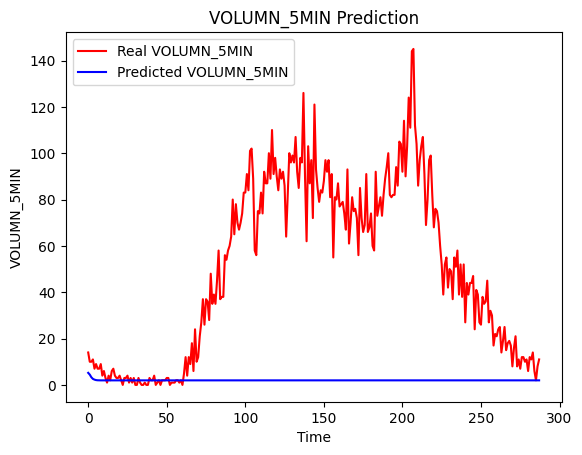

In [92]:
# 画图对比
plt.plot(test_data[:fut_pred], color = 'red', label = 'Real VOLUMN_5MIN')
plt.plot(actual_predictions, color = 'blue', label = 'Predicted VOLUMN_5MIN')
plt.title('VOLUMN_5MIN Prediction')
plt.xlabel('Time')
plt.ylabel('VOLUMN_5MIN')
plt.legend()
plt.show()

In [ ]:
# 网格搜索训练模型

# 超参数取值范围
learning_rates = [0.001]
hidden_layer_sizes = [100]
epochs = 150
# 创建字典，用于存储每组超参数对应的训练结果
results = {}

# 嵌套循环遍历所有可能的超参数组合
for learning_rate in learning_rates:
    for hidden_layer_size in hidden_layer_sizes:
        
        # 初始化模型、损失函数和优化器
        model = LSTM(hidden_layer_size=hidden_layer_size).to(device)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        print("##############################")
        print(model)
        print('learning_rate:',learning_rate)
        print("##############################")
        # 训练过程
        for epoch in range(epochs):
            total_loss = 0

            for seq, labels in train_inout_seq:
                optimizer.zero_grad()
                model.hidden_cell = (torch.zeros(1, 1, hidden_layer_size).to(device),
                                     torch.zeros(1, 1, hidden_layer_size).to(device))

                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                total_loss += single_loss.item()
                single_loss.backward()
                optimizer.step()

            if epoch % 30 == 1:
                avg_loss = total_loss / len(train_inout_seq)
                smape_score = smape(torch.tensor(y_pred), torch.tensor(labels))
                print(f'epoch: {epoch:3} loss: {avg_loss:10.8f}')
                print(f'SMAPE: {smape_score.item():10.8f}')
        
        # 记录评估结果
        results[(learning_rate, hidden_layer_size)] = smape_score.item()

In [ ]:
results

In [ ]:
# 根据评估结果选择最佳超参数组合
best_params = min(results, key=results.get)

# 使用最佳超参数重新训练模型
best_learning_rate, best_hidden_layer_size = best_params
best_model = LSTM(hidden_layer_size=best_hidden_layer_size).to(device)
best_optimizer = torch.optim.Adam(best_model.parameters(), lr=best_learning_rate)
best_params`

In [ ]:
# TESTDATA验证模型效果
# 设定预测时间步数
fut_pred = 288

# 初始化输入序列为最后一个训练序列
test_inputs = train_data_normalized[-train_window:].tolist()

# 将模型设置为评估模式
best_model.eval()

# 迭代预测未来的每个时间步
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
    with torch.no_grad():
        best_model.hidden_cell = (torch.zeros(1, 1, best_hidden_layer_size).to(device),
                        torch.zeros(1, 1, best_hidden_layer_size).to(device))
        test_inputs.append(best_model(seq).item())

# 反归一化预测结果并输出
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
print(actual_predictions)

In [ ]:
# 画图对比
plt.plot(test_data[:fut_pred], color = 'red', label = 'Real VOLUMN_5MIN')
plt.plot(actual_predictions, color = 'blue', label = 'Predicted VOLUMN_5MIN')
plt.title('VOLUMN_5MIN Prediction')
plt.xlabel('Time')
plt.ylabel('VOLUMN_5MIN')
plt.legend()
plt.show()

In [ ]:
# 预测28日的车流量
# 设定预测时间步数
fut_pred = 288


# 最后30个数据归一化处理
test_data_normalized2 = scaler.transform(test_data .reshape(-1, 1))

# 初始化输入序列为最后一个序列
pre_inputs2 = test_data_normalized2[-train_window:].tolist()
pre_inputs2

In [ ]:
# 将模型设置为评估模式
best_model.eval()

# 迭代预测未来的每个时间步
for i in range(fut_pred):
    seq = torch.FloatTensor(pre_inputs[-train_window:]).to(device)
    with torch.no_grad():
        best_model.hidden_cell = (torch.zeros(1, 1, best_hidden_layer_size).to(device),
                        torch.zeros(1, 1, best_hidden_layer_size).to(device))
        pre_inputs.append(best_model(seq).item())

# 反归一化预测结果并输出
actual_pred_28 = scaler.inverse_transform(np.array(pre_inputs[train_window:]).reshape(-1, 1))
print(actual_pred_28)